In [1]:
# Import 
import os
import time
import json
import datetime
import zipfile
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model

from tyssue.core.history import HistoryHdf5



In [2]:
def open_sheet(dirname, t, data_names=['vert', 'edge', 'face', 'cell']):
    """Open hdf5 file

    Open HDF5 file correspond to t time from dirname directory.

    Parameters
    ----------
    directory : str
        complete directory path
    t : int
        time step
    """
    file_name = 'invagination_{:04d}.hf5'.format(t)
    dsets = hdf5.load_datasets(os.path.join(dirname, file_name),
                               data_names=data_names)

    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('ellipse', dsets, specs)
    return sheet

def edge_projected_stress(sheet, model):

    force = -model.compute_gradient(sheet)
    srce_force = sheet.upcast_srce(force)
    trgt_force = sheet.upcast_trgt(force)
    stress = (
        (srce_force - trgt_force)
        * sheet.edge_df[['u' + c for c in sheet.coords]].values
    ).sum(axis=1)

    return stress

from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension, BarrierElasticity
model = model_factory(
    [
        RadialTension,
        BarrierElasticity,
        effectors.LineTension,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [23]:

import matplotlib.pyplot as plt
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/20190917-QSSolver-Homogenous_Clone')
dirname = SIM_DIR/'1.08_shrink_1.08_constriction_80.0_radialtension0/'
history = HistoryHdf5.from_archive(dirname/'out.hf5')
sheet = history.retrieve(100)
sheet.face_df.time.unique()


array([100.])

[24.]


/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


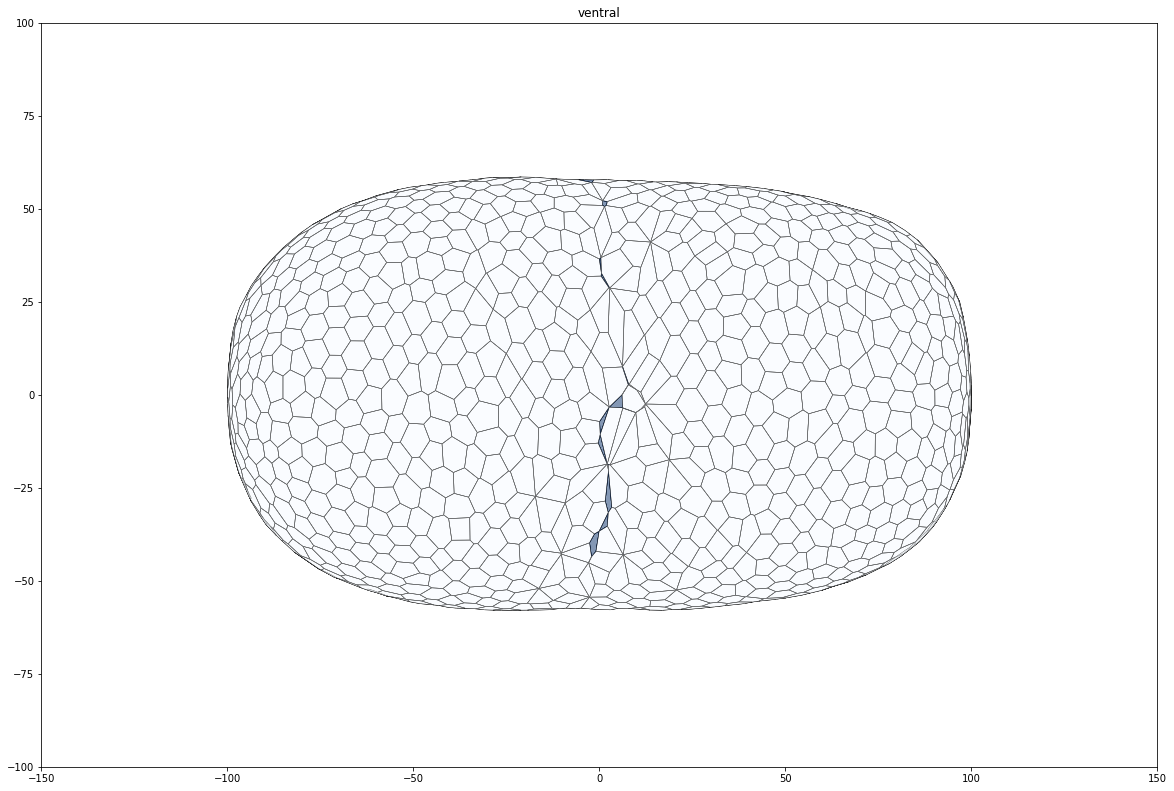

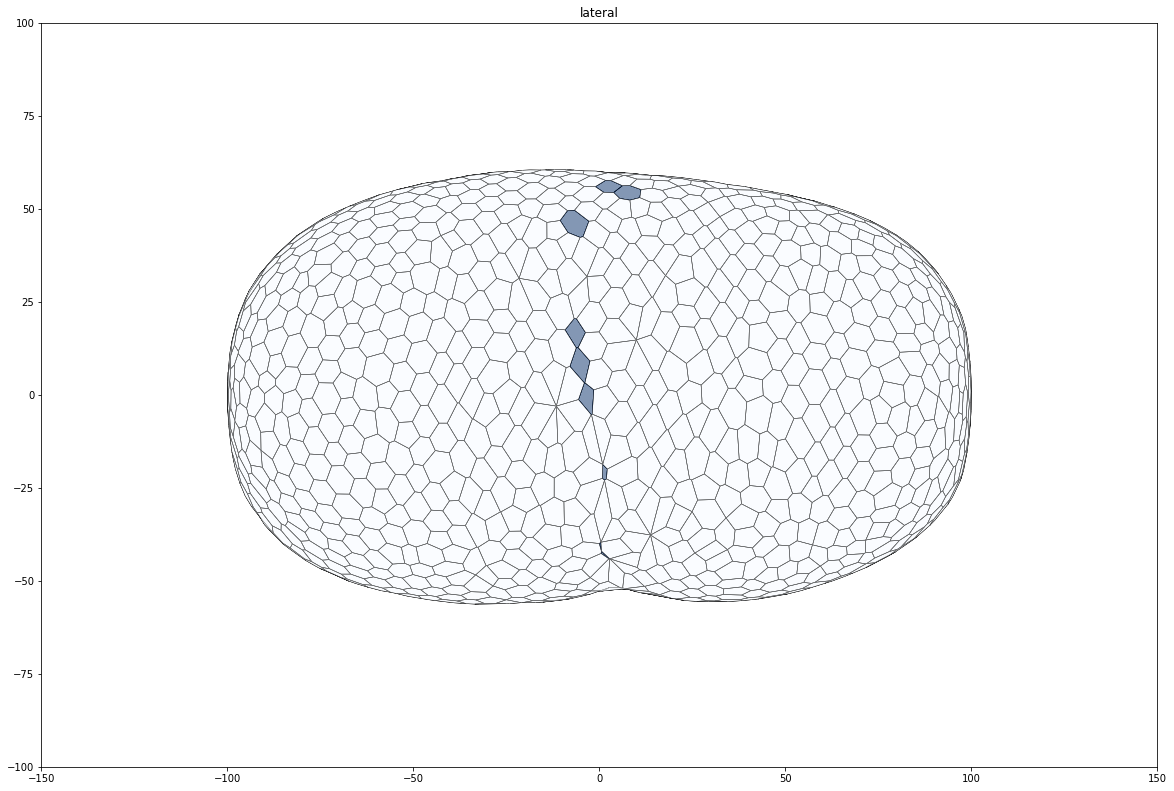

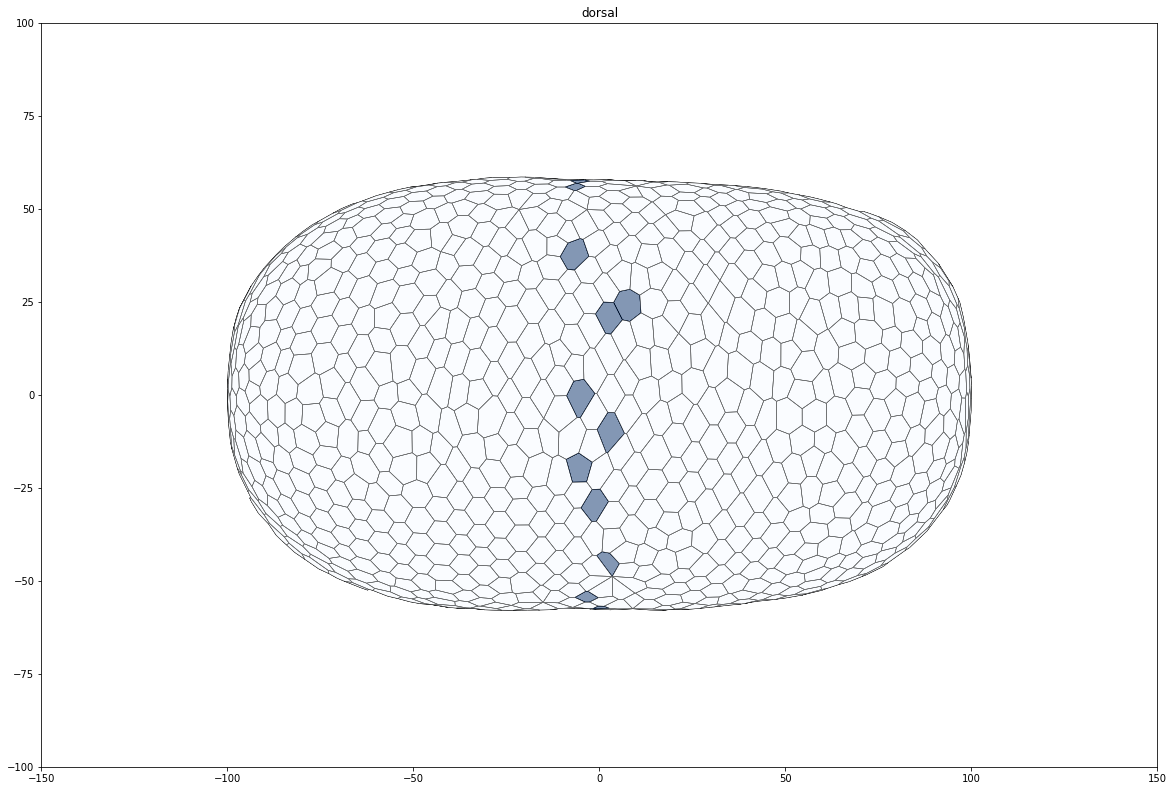

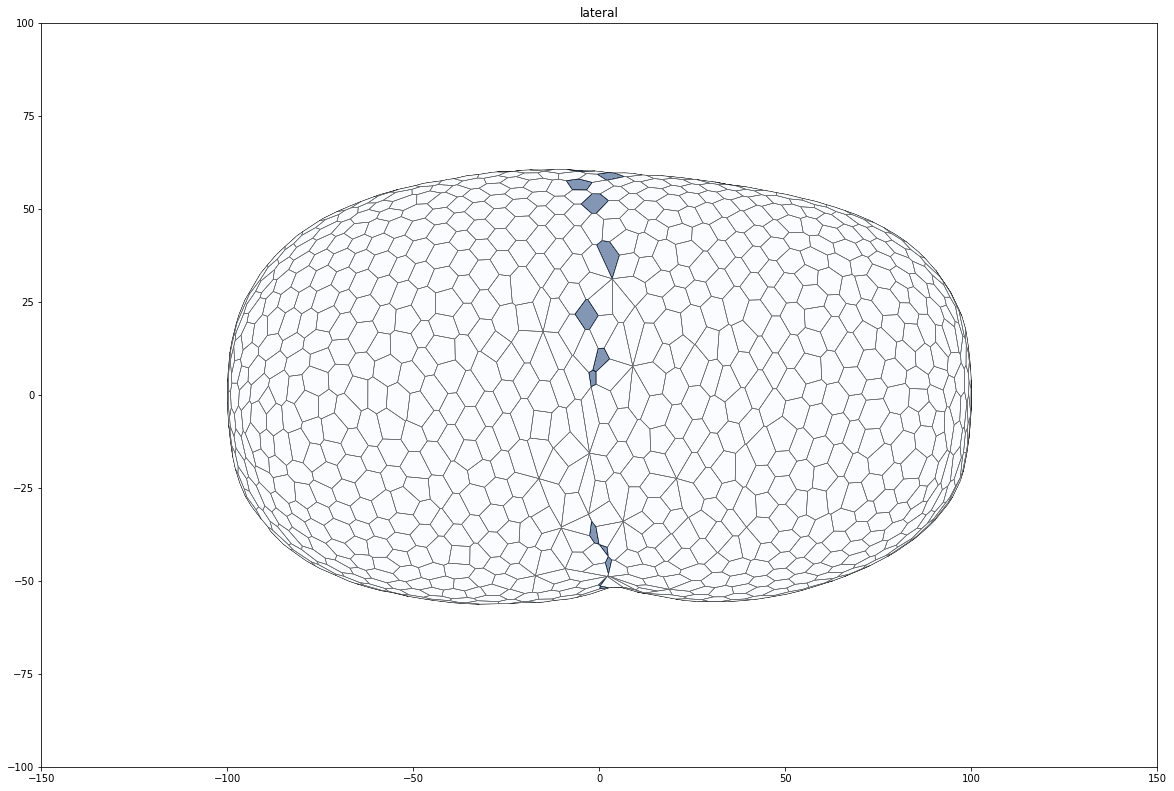

In [718]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/20190913-QSSolver-Homogenous_Control')
dirname = SIM_DIR/'1.08_constriction_30.0_radialtension0/'
history = HistoryHdf5.from_archive(dirname/'out.hf5')
sheet = history.retrieve(50)
print(sheet.face_df.time.unique())


from tyssue.draw import sheet_view
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis,
            'colormap': 'Blues',
            'alpha':0.5

        },
        
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs



sheet2=sheet.extract_bounding_box(x_boundary=(-150,0))
fig, ax = sheet_view(sheet2, ['z', 'y'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("ventral")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet2, ['z', 'x'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("lateral")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(x_boundary=(0,150))
fig, ax = sheet_view(sheet2, ['z', 'y'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("dorsal")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(y_boundary=(-150,0))
fig, ax = sheet_view(sheet2, ['z', 'x'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("lateral")
fig.set_size_inches(20,20)

In [613]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/20190912-QSSolver-Prepolarized_Control')
dirname = SIM_DIR/'1.08_constriction_30.0_radialtension0/'



sheet = open_sheet(dirname,0)
sheet.face_df['time']=0.0
sheet.edge_df['time']=0.0
sheet.vert_df['time']=0.0
history = HistoryHdf5(sheet, 
                      extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                     hf5file=os.path.join(dirname, 'out.hf5'))

for t in np.arange(0.0, 200.0):
    try:
        sheet = open_sheet(dirname,int(t))
        sheet.face_df['radial_tension'] = np.float32(sheet.face_df['radial_tension'])
        sheet.face_df['time']=t
        sheet.edge_df['time']=t
        sheet.vert_df['time']=t
        sheet.face_df.to_csv(os.path.join(dirname, "face.csv"), mode='a')
        sheet.edge_df.to_csv(os.path.join(dirname, "edge.csv"), mode='a')
        sheet.vert_df.to_csv(os.path.join(dirname, "vert.csv"), mode='a')
        history.record(sheet=sheet, time_stamp=t)
    except Exception:
        pass

pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))

#Faire le zip avec la bibliothèque shutil plutôt ? 
with zipfile.ZipFile(os.path.join(dirname, str(dirname).split('/')[-1]+'.zip'), 'w') as zip :
    zip.write(os.path.join(dirname, "face.csv"), arcname='face.csv')
    zip.write(os.path.join(dirname, "edge.csv"), arcname='edge.csv')
    zip.write(os.path.join(dirname, "vert.csv"), arcname='vert.csv')
    zip.write(os.path.join(dirname, "settings.csv"), arcname='settings.csv')
    
#os.remove(os.path.join(dirname, "settings.csv"))
os.remove(os.path.join(dirname, "face.csv"))
os.remove(os.path.join(dirname, "edge.csv"))
os.remove(os.path.join(dirname, "vert.csv"))


FileNotFoundError: file /home/admin-suz/Documents/Simulations/20190912-QSSolver-Prepolarized_Control/1.08_constriction_30.0_radialtension0/invagination_0000.hf5 not found